In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from rnn import RNN
import torch
import torch.nn.functional as F
import tqdm
from torch import matmul, sigmoid, tanh

sns.set_style("whitegrid")

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
X = np.load("data/x.npy")
Y = np.load("data/y.npy")
meta = np.load("data/meta.npy")
klassennamen = np.load("data/classnames.npy")
classnames = klassennamen


In [3]:
model = RNN(input_dim=13, nclasses=33, hidden_dims=32,
                      num_rnn_layers=4, dropout=0.710883, bidirectional=True)
model.load("rnn.pth")
model.eval()


loading model from rnn.pth


RNN(
  (inlayernorm): LayerNorm(torch.Size([13]), eps=1e-05, elementwise_affine=True)
  (clayernorm): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(13, 32, num_layers=4, bias=False, batch_first=True, dropout=0.710883, bidirectional=True)
  (linear_class): Linear(in_features=256, out_features=33, bias=True)
)

In [4]:
model.lstm

LSTM(13, 32, num_layers=4, bias=False, batch_first=True, dropout=0.710883, bidirectional=True)

In [5]:
list(model.lstm.modules())[0]

LSTM(13, 32, num_layers=4, bias=False, batch_first=True, dropout=0.710883, bidirectional=True)

In [6]:
# get weight tensors of the first layer forward pass (l0)
weight_hh = model.lstm.weight_hh_l0
weight_ih = model.lstm.weight_ih_l0

w_ii, w_if, w_ig, w_io = weight_ih.chunk(4, 0)
w_hi, w_hf, w_hg, w_ho = weight_hh.chunk(4, 0)

w_i = torch.cat([w_ii,w_hi],dim=1)
w_f = torch.cat([w_if,w_hf],dim=1)
w_g = torch.cat([w_ig,w_hg],dim=1)
w_o = torch.cat([w_io,w_ho],dim=1)

[(-0.5, 12.5, 31.5, -0.5),
 (-0.5, 12.5, 31.5, -0.5),
 (-0.5, 12.5, 31.5, -0.5),
 (-0.5, 12.5, 31.5, -0.5),
 (-0.5, 31.5, 31.5, -0.5),
 (-0.5, 31.5, 31.5, -0.5),
 (-0.5, 31.5, 31.5, -0.5),
 (-0.5, 31.5, 31.5, -0.5)]

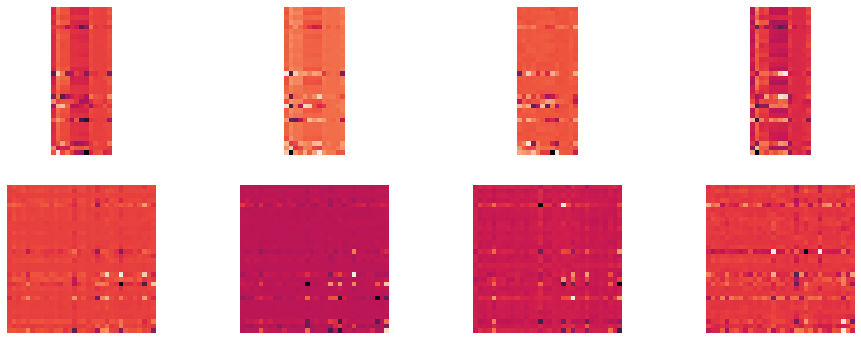

In [7]:
fix, axs = plt.subplots(2,4, figsize=(16,6))
axs[0,0].imshow(w_ii.detach().numpy())
axs[0,1].imshow(w_if.detach().numpy())
axs[0,2].imshow(w_ig.detach().numpy())
axs[0,3].imshow(w_io.detach().numpy())
axs[1,0].imshow(w_hi.detach().numpy())
axs[1,1].imshow(w_hf.detach().numpy())
axs[1,2].imshow(w_hg.detach().numpy())
axs[1,3].imshow(w_ho.detach().numpy())

[ax.axis('off') for ax in axs.reshape(-1)]

In [8]:
(Y[:,0]==8).argmax()

27

In [9]:
idx = 7

x = X[idx]
y = Y[idx,0]
x = torch.from_numpy(x)

model.forward(x[None,:,:])

# for later plotting
i_all = list()
f_all = list()
g_all = list()
o_all = list()
h_all = list()
c_all = list()

h_prev = torch.zeros(32)
c_prev = torch.zeros(32)

for t in range(x.shape[0]):
    
    # append previous information t-1 with current information
    xh = torch.cat([x[t,:],h_prev])

    i = sigmoid(matmul(w_i, xh))
    f = sigmoid(matmul(w_f, xh))
    g = tanh(matmul(w_g, xh))
    o = sigmoid(matmul(w_o, xh))
    
    c = f*c_prev + i*g
    h = o*tanh(c)
    
    # update c, h for next iteration
    h_prev = h
    c_prev = c

    # store gates for later plotting
    i_all.append(i)
    f_all.append(f)
    g_all.append(g)
    o_all.append(o)
    h_all.append(h)
    c_all.append(c)
    
i_all = torch.stack(i_all)
f_all = torch.stack(f_all)
g_all = torch.stack(g_all)
o_all = torch.stack(o_all)
h_all = torch.stack(h_all)
c_all = torch.stack(c_all)

writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/x.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/i.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/f.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/o.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/g.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/h.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/c.csv


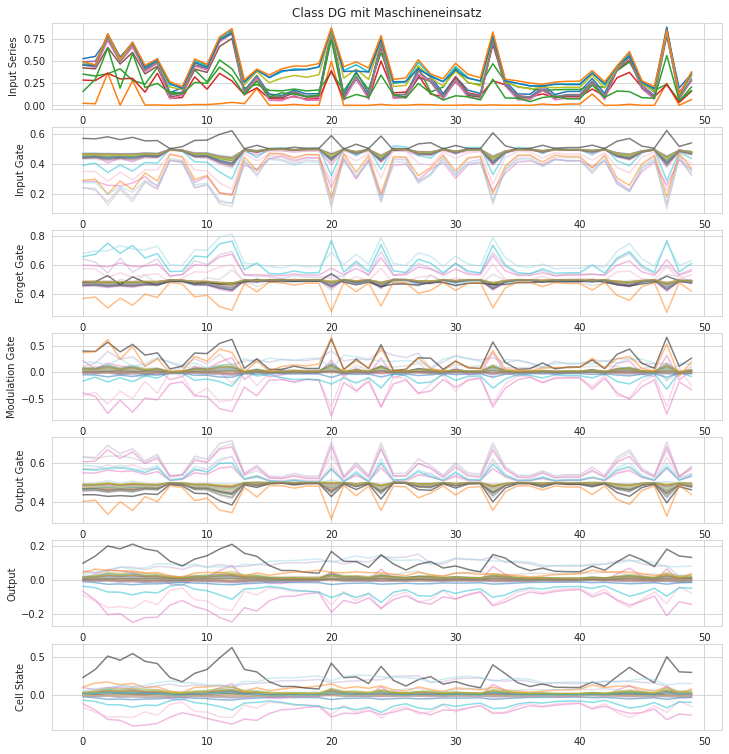

In [10]:
import matplotlib.pylab as pl

hidden_dims = 32

colors = pl.cm.tab20(np.linspace(0,1,hidden_dims))

# positive spike for clouds
colors[30] = np.array([0,0,0,0])

fig, axs = plt.subplots(7,1, figsize=(12,13))

# randomize the sequence in which the lines are plotted (on top of each other...)
plotting_idxs = np.arange(hidden_dims)
np.random.shuffle(plotting_idxs)

axs[0].plot(x.detach().numpy())
axs[0].set_ylabel("Input Series")
axs[0].set_title("Class {}".format(classnames[y]))
[axs[1].plot(i_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[1].set_ylabel("Input Gate")
[axs[2].plot(f_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[2].set_ylabel("Forget Gate")
[axs[3].plot(g_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[3].set_ylabel("Modulation Gate")
[axs[4].plot(o_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[4].set_ylabel("Output Gate")
[axs[5].plot(h_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[5].set_ylabel("Output")
[axs[6].plot(c_all[:,i].detach().numpy(), color=colors[i], alpha=0.5, label="hidden dim {}".format(i)) for i in range(hidden_dims)]
axs[6].set_ylabel("Cell State")
#axs[7].legend()

path="/home/marc/projects/Phiweek19_Presentation/images/rnn_examples"

import pandas as pd
os.makedirs(os.path.join(path,str(idx)), exist_ok=True)

df = pd.DataFrame(x.detach().numpy(), columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(path,str(idx),"x.csv"))
print("writing: "+os.path.join(path,str(idx),"x.csv"))

for name, tensor in zip(["i","f","o","g","h","c"],[i_all,f_all,o_all,g_all,h_all,c_all]):
    df = pd.DataFrame(tensor.detach().numpy())
    df.index.name="t"
    df.to_csv(os.path.join(path,str(idx),name+".csv"))
    print("writing: "+os.path.join(path,str(idx),name+".csv"))

In [18]:
x_ = torch.autograd.Variable(x[None,:,:], requires_grad=True)
logprobabilities = model.forward(x_)
logprobabilities.exp().max().backward()
dydx = x_.grad

tensor([[[-1.0211e-02, -4.1779e-03,  1.7164e-03, -4.6882e-04, -3.0303e-03,
          -1.8842e-03,  2.4886e-03,  1.1471e-02,  5.3435e-03, -1.5164e-03,
          -1.0802e-03, -1.6160e-03,  2.9649e-03],
         [-2.4366e-03, -9.1783e-04,  1.1700e-04,  2.0138e-04, -4.8288e-04,
          -6.0296e-05, -1.5649e-03,  3.3348e-03,  1.1596e-03,  3.4638e-05,
           4.7350e-05,  1.7199e-05,  5.5059e-04],
         [-1.2555e-03, -2.3329e-03,  5.0810e-04,  1.0041e-03, -1.1252e-03,
           3.3116e-03, -5.3535e-03,  5.4457e-03,  4.7866e-04, -5.7894e-04,
          -5.9188e-04, -6.0746e-04,  1.0973e-03],
         [ 7.0627e-04, -9.6460e-04, -5.8300e-04, -3.3596e-04,  3.4755e-04,
           5.1464e-04, -2.4107e-04, -8.0785e-04,  4.2413e-05, -1.6952e-04,
          -2.4309e-04, -1.7285e-04,  1.9071e-03],
         [-1.2289e-03, -1.1404e-03,  5.1089e-04,  3.1111e-04, -9.7483e-04,
           1.8048e-03, -3.3063e-03,  3.4792e-03,  7.5921e-04, -3.1442e-04,
          -2.9874e-04, -3.1450e-04,  7.1288e-04],


writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/7/dydx.csv


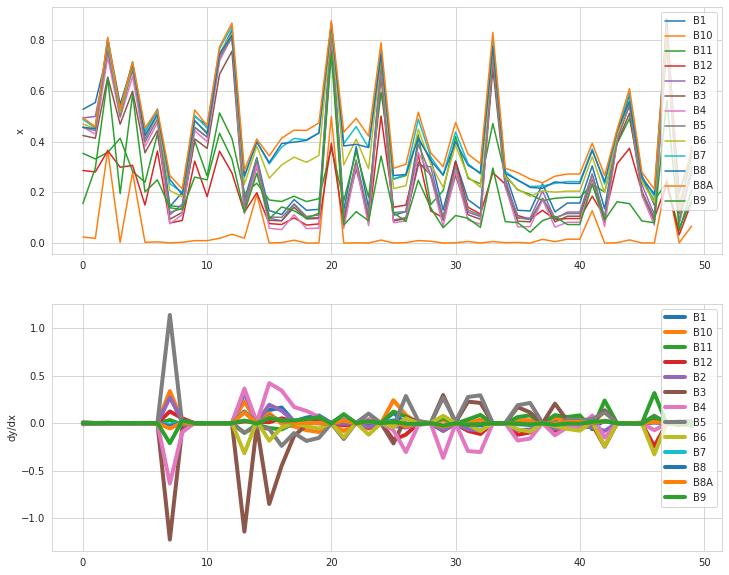

In [12]:
fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_[0].detach().numpy())
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_.grad[0].numpy(),linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

df = pd.DataFrame(x_.grad[0].numpy(), columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(path,str(idx),"dydx.csv"))
print("writing: "+os.path.join(path,str(idx),"dydx.csv"))

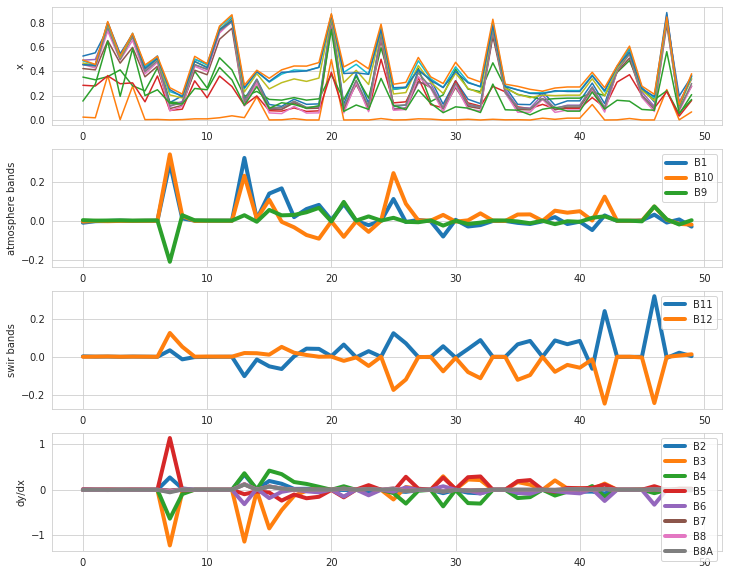

In [13]:
fig, axs = plt.subplots(4, figsize=(12,10))
axs[0].plot(x_[0].detach().numpy())
axs[0].set_ylabel("x")
axs[1].plot(x_.grad[0,:,[0,1,12]].numpy(),linewidth=4)
axs[1].set_ylabel("atmosphere bands")
axs[1].legend(np.array(BANDS)[[0,1,12]])
axs[2].plot(x_.grad[0,:,[2,3]].numpy(),linewidth=4)
axs[2].legend(np.array(BANDS)[[2,3]])
axs[2].set_ylabel("swir bands")
axs[3].plot(x_.grad[0,:,4:12].numpy(),linewidth=4)
axs[3].set_ylabel("dy/dx")
axs[3].legend(np.array(BANDS)[4:12])

In [14]:
dweight_hh = model.lstm.weight_hh_l0.grad
dweight_ih = model.lstm.weight_ih_l0.grad

dw_ii, dw_if, dw_ig, dw_io = weight_ih.chunk(4, 0)
dw_hi, dw_hf, dw_hg, dw_ho = weight_hh.chunk(4, 0)

dw_i = torch.cat([w_ii,w_hi],dim=1)
dw_f = torch.cat([w_if,w_hf],dim=1)
dw_g = torch.cat([w_ig,w_hg],dim=1)
dw_o = torch.cat([w_io,w_ho],dim=1)

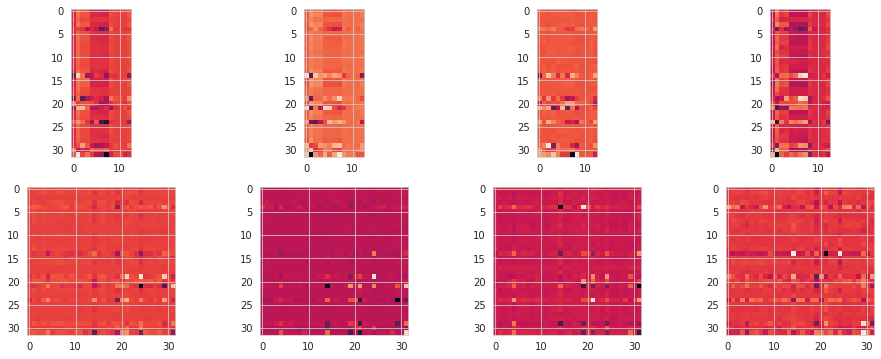

In [15]:
fix, axs = plt.subplots(2,4, figsize=(16,6))
axs[0,0].imshow(dw_ii.detach().numpy())
axs[0,1].imshow(dw_if.detach().numpy())
axs[0,2].imshow(dw_ig.detach().numpy())
axs[0,3].imshow(dw_io.detach().numpy())
axs[1,0].imshow(dw_hi.detach().numpy())
axs[1,1].imshow(dw_hf.detach().numpy())
axs[1,2].imshow(dw_hg.detach().numpy())
axs[1,3].imshow(dw_ho.detach().numpy())

#[ax.axis('off') for ax in axs.reshape(-1)]

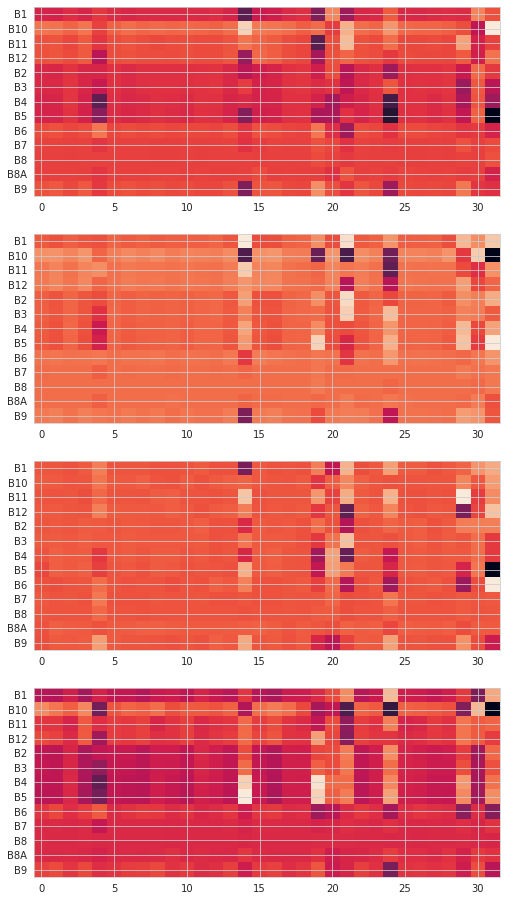

In [16]:
fix, axs = plt.subplots(4, figsize=(16,16))
axs[0].imshow(dw_ii.detach().numpy().T)
axs[1].imshow(dw_if.detach().numpy().T)
axs[2].imshow(dw_ig.detach().numpy().T)
axs[3].imshow(dw_io.detach().numpy().T)

for ax in axs.reshape(-1):
    ax.set_yticks(np.arange(len(BANDS)))
    ax.set_yticklabels(BANDS)

In [17]:
BANDS

['B1',
 'B10',
 'B11',
 'B12',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9']